In [92]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import time
import logging
from multiprocessing import Pool, cpu_count

import ray
import sys

from visualize.linear_env.robust_adaptive_lqr.python import utils
from visualize.linear_env.robust_adaptive_lqr.python import examples
from visualize.linear_env.robust_adaptive_lqr.python.optimal import OptimalStrategy
from visualize.linear_env.robust_adaptive_lqr.python.nominal import NominalStrategy
from visualize.linear_env.robust_adaptive_lqr.python.ofu import OFUStrategy
from visualize.linear_env.robust_adaptive_lqr.python.sls import SLS_FIRStrategy, SLS_CommonLyapunovStrategy, sls_common_lyapunov, SLSInfeasibleException
from visualize.linear_env.robust_adaptive_lqr.python.ts import TSStrategy
from visualize.linear_env.robust_adaptive_lqr.python.rl_agent import RLStrategy

import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')

logging.basicConfig(level=logging.WARN)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
# PARAMETERS
rng = np.random
horizon = 100
trials_per_method = 20
ray.init(ignore_reinit_error=True)

2020-04-15 23:53:32,377	WARNING worker.py:673 -- WARNING: Not updating worker name since `setproctitle` is not installed. Install this with `pip install setproctitle` (or ray[debug]) to enable monitoring of worker processes.
2020-04-15 23:53:32,377	ERROR worker.py:679 -- Calling ray.init() again after it has already been called.


## Defining True System Dynamics

In [107]:
def set_up_example(A_star, B_star, qr_ratio, prime_horizon, prime_excitation, sigma_excitation=0.1):
    n,p = B_star.shape
    # design a stabilizing controller
    _, K_init = utils.dlqr(A_star, B_star, 1e-3*np.eye(n), np.eye(p))
    assert utils.spectral_radius(A_star + B_star.dot(K_init)) < 1
    Q = qr_ratio * np.eye(n)
    R = np.eye(p)
    sigma_w = 1
    return A_star, B_star, K_init, Q, R, prime_horizon, prime_excitation, sigma_excitation, sigma_w

def laplacian_dynamics(qr_ratio=1e1, prime_horizon=100, prime_excitation=1):
    A_star, B_star = examples.unstable_laplacian_dynamics()
    return set_up_example(A_star, B_star, qr_ratio, prime_horizon, prime_excitation)

def unstable_dynamics(qr_ratio=1e1, prime_horizon=250, prime_excitation=2):
    A_star, B_star = examples.transient_dynamics(diag_coeff=2, upperdiag=4)
    return set_up_example(A_star, B_star, qr_ratio, prime_horizon, prime_excitation, sigma_excitation=0.1)

In [96]:
example = laplacian_dynamics() # unstable_dynamics()
A_star, B_star, K_init, Q, R, prime_horizon, prime_excitation, sigma_excitation, sigma_w = example

print(A_star)
print(B_star)
print(K_init)
print("prime_horizon", prime_horizon)
print("prime_excitation", prime_excitation)
print("sigma_excitation", sigma_excitation)
print(np.linalg.eigvals(A_star + B_star @ K_init))

[[-1.01 -0.01 -0.  ]
 [-0.01 -1.01 -0.01]
 [-0.   -0.01 -1.01]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[0.04373095 0.01250864 0.00126936]
 [0.01250864 0.04500031 0.01250864]
 [0.00126936 0.01250864 0.04373095]]
prime_horizon 100
prime_excitation 1
sigma_excitation 0.1
[-0.96145194 -0.96753841 -0.96854745]


# Constructors for different adaptive methods

In [97]:
def optimal_ctor():
    return OptimalStrategy(Q=Q, R=R, A_star=A_star, B_star=B_star, sigma_w=sigma_w)

def nominal_ctor():
    return NominalStrategy(Q=Q,
                          R=R,
                          A_star=A_star,
                          B_star=B_star,
                          sigma_w=sigma_w,
                          sigma_explore=sigma_excitation,
                          reg=1e-5,
                          epoch_multiplier=10, rls_lam=None)

def rl_ctor():
    import ipdb; ipdb.set_trace()
    return RLStrategy(Q=Q,
                      R=R,
                      A_star=A_star,
                      B_star=B_star,
                      sigma_w=sigma_w,
                      sigma_explore=sigma_excitation,
                      reg=1e-5,
                      epoch_multiplier=10, rls_lam=None)

def ofu_ctor():
    return OFUStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  reg=1e-5,
                  actual_error_multiplier=1, rls_lam=None)

def ts_ctor():
    return TSStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  reg=1e-5,
                  tau=500,
                  actual_error_multiplier=1, rls_lam=None)

def sls_fir_ctor():
    return SLS_FIRStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  sigma_explore=sigma_excitation,
                  reg=1e-5,
                  epoch_multiplier=10,
                  truncation_length=12,
                  actual_error_multiplier=1, rls_lam=None)

def sls_cl_ctor():
    return SLS_CommonLyapunovStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  sigma_explore=sigma_excitation,
                  reg=1e-5,
                  epoch_multiplier=10,
                  actual_error_multiplier=1, rls_lam=None)

# Helper methods for running in parallel

In [8]:
prime_seed = 45727
def run_one_trial(new_env_ctor, seed, prime_fixed=False):
    rng = np.random.RandomState(seed)
    if prime_fixed: # reducing variance
        rng_prime = np.random.RandomState(prime_seed) 
    else:
        rng_prime = rng
    env = new_env_ctor()
    env.reset(rng_prime)
    env.prime(prime_horizon, K_init, prime_excitation, rng_prime)
    regret = np.array([env.step(rng) for _ in range(horizon)])
    env.complete_epoch(rng)
    err, cost = env.get_statistics(iteration_based=True)
    return regret, err, cost

def spawn_invocation(method, p, prime_fixed=False):
    seed = np.random.randint(0xFFFFFFFF)
    ctor = {
        'optimal': optimal_ctor,
        'nominal': nominal_ctor,
        'ofu': ofu_ctor,
        'ts': ts_ctor,
        'sls_fir': sls_fir_ctor,
        'sls_cl': sls_cl_ctor,
        "rl": rl_ctor
    }[method]
    return (p.apply_async(run_one_trial, (ctor, seed, prime_fixed)), seed)

def process_future_list(ftchs):
    regrets = []
    errors = []
    costs = []
    seeds = []
    bad_invocations = 0
    for ftch, seed in ftchs:
        try:
            reg, err, cost = ftch.get()
        except Exception as e:
            bad_invocations += 1
            continue
        regrets.append(reg)
        errors.append(err)
        costs.append(cost)
        seeds.append(seed)
    return np.array(regrets), np.array(errors), np.array(costs), np.array(seeds), bad_invocations

In [24]:
run_one_trial(optimal_ctor, 0, prime_fixed=False)

AttributeError: module 'utils' has no attribute 'dlqr'

# Running experiments and plotting results

In [108]:
strategies = ['optimal', 'nominal', 'ofu', 'ts']#, 'sls_cl', 'sls_fir']
start_time = time.time()
with Pool(processes=cpu_count()) as p:
    all_futures = [[spawn_invocation(method, p, prime_fixed=True) 
                    for _ in range(trials_per_method)] for method in strategies]
    list_of_results = [process_future_list(ftchs) for ftchs in all_futures]
print("finished execution in {} seconds".format(time.time() - start_time))

finished execution in 3.6610512733459473 seconds


In [ ]:
regret_list = []
err_list = []
cost_list = []
for i in range(trials_per_method):
    regret, err, cost = run_one_trial(rl_ctor, i, prime_fixed=False)
    regret_list.append(regret)
    err_list.append(err)
    cost_list.append(cost)

list_of_results.append([regret_list, err_list, cost_list, list_of_results[0][3], 0])

reward targets are [-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.]


In [104]:
def get_errorbars(regrets, q=10, percent_bad=0):
    median = np.percentile(regrets, q=50-percent_bad, axis=0)
    low10 = np.percentile(regrets, q=q, axis=0)
    high90 = np.percentile(regrets, q=100-(q-percent_bad), axis=0)
    return median, low10, high90

def plot_list_medquantile(datalist, legendlist=None, xlabel=None, ylabel=None, semilogy=False, 
                          loc='upper left', alpha=0.1, figsize=(8,4)):
    rgblist = sns.color_palette('viridis', len(datalist))
    plt.figure(figsize=figsize)
    for idx, data in enumerate(datalist):
        median, lower, higher = data
        if semilogy:
            plt.semilogy(range(len(median)), median, color=rgblist[idx], label=legendlist[idx])
        else:
            plt.plot(range(len(median)), median, color=rgblist[idx], label=legendlist[idx])
        plt.fill_between(np.array(np.arange(len(median))), median.astype(np.float), 
                        higher.astype(np.float), color=rgblist[idx], alpha=alpha)
    if legendlist is not None:
        plt.legend(loc=loc)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

rl bad_invocations 0
ofu bad_invocations 0
ts bad_invocations 0
nominal bad_invocations 0
optimal bad_invocations 0


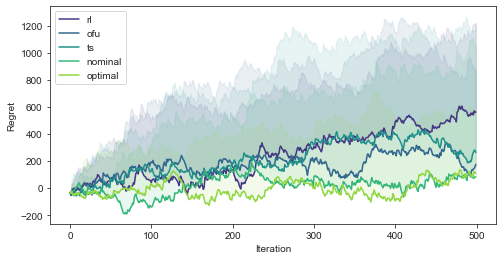

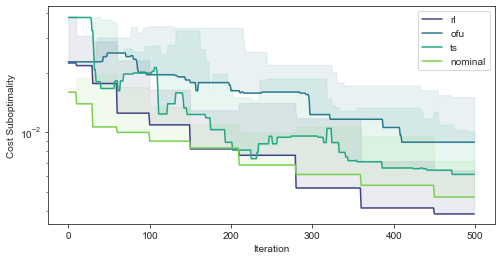

In [105]:
regretlist = []
costs_list = []

# strat_rearranged =  [strategies[2], strategies[3], strategies[5], strategies[1], strategies[0]]
# res_rearranged =  [list_of_results[2], list_of_results[3], list_of_results[5], list_of_results[1], list_of_results[0]]

strat_rearranged =  ['rl', strategies[2], strategies[3], strategies[1], strategies[0]]
res_rearranged =  [list_of_results[4], list_of_results[2], list_of_results[3], list_of_results[1], list_of_results[0]]

for name, result in zip(strat_rearranged, res_rearranged):
    regrets, errors, costs, _, bad_invocations = result
    print(name, "bad_invocations", bad_invocations)
    percent_bad = bad_invocations / trials_per_method * 100
    regretlist.append(get_errorbars(regrets, q=10, percent_bad=percent_bad))
    costs_list.append(get_errorbars(costs, q=10, percent_bad=percent_bad))

sns.set_palette("muted")
plot_list_medquantile(regretlist, legendlist=strat_rearranged, xlabel="Iteration", ylabel="Regret")
plot_list_medquantile(costs_list[:-1], legendlist=strat_rearranged[:-1], xlabel="Iteration", 
                      ylabel="Cost Suboptimality", semilogy=True, loc='upper right')
